In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import itertools
from collections import OrderedDict
from functools import partial

from sklearn.datasets import load_svmlight_file


from links import LinksClassifier
from logit import LogisticRegressionPairwise, LogisticRegression


from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, GridSearchCV

from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
datafiles_toy = [
    r'data/diabetes_scale.libsvm',
    r'data/australian_scale.libsvm',
    r'data/breast-cancer_scale.libsvm',
    r'data/german.numer_scale.libsvm',
    r'data/ionosphere_scale.libsvm',
    r'data/liver-disorders_scale.libsvm',
    r'data/heart_scale.libsvm',
]

In [4]:
def loader(name):
    from sklearn.datasets import load_svmlight_file
    from scipy.sparse import issparse
    filename = 'data/%s.libsvm' % name
    if not name in globals():
        X, y = load_svmlight_file(filename)
        if issparse(X):
            X = X.toarray()
        globals()[name] = (X, y)
    return globals()[name]

In [5]:
datasets = OrderedDict([(os.path.split(f)[-1].replace('.libsvm', ''),
                             partial(loader, os.path.split(f)[-1].replace('.libsvm', '')))
                            for f in datafiles_toy])

In [6]:
X, y= datasets.values()[0]()

In [7]:
def sample_links_random(X, y, percent_links):
        # np.random.seed(44)
    num = int(len(y) * percent_links)

    choice1 = np.random.choice(len(y), size=num, replace=True)
    X1 = X[choice1]
    choice2 = np.random.choice(len(y), size=num, replace=True)
    X2 = X[choice2]
    z = (y[choice1] == y[choice2]).astype(float)

    return X1, X2, z



In [8]:
def split_dataset(X,y, percent_labels, percent_links):
    X1, X2, z = sample_links_random(X, y, percent_links)
    n_labels = int(len(y) * percent_labels)
    labels_choice = next(StratifiedShuffleSplit(n_splits=1, train_size=percent_labels).split(X, y))[0]
    return X[labels_choice], y[labels_choice], X1, X2, z

In [9]:
X_r,y_r, X1, X2, z = split_dataset(X, y, percent_labels=0.4, percent_links=0.3)

In [10]:
def accuracy_scorer(estimator, X, y):
    import numpy as np
    from sklearn.metrics import accuracy_score
    y_pred = estimator.predict(X)
    y_true = np.copy(y)
    y_true[y_true == -1] = 0
    return accuracy_score(y_true, y_pred)

In [11]:
estimator = LinksClassifier(sampling='predefined')


grid = {
    'alpha': [0.01, 0.1, 1,10],
    'kernel_gamma':['auto'],
    'kernel': ['rbf'],
    'gamma':[0.1, 0.1, 1, 10]    
}

In [12]:
percent_labels_range = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
percent_links_range = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
outer_cv = list(StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42).split(X, y))


train_scores = np.zeros(shape=(len(percent_labels_range), len(percent_links_range), len(outer_cv)))
test_scores = np.zeros(shape=(len(percent_labels_range), len(percent_links_range), len(outer_cv)))

for (i_label, p_labels), (i_link, p_links) in \
                        tqdm(list(itertools.product(enumerate(percent_labels_range), enumerate(percent_links_range)))):
    print('labels=%.2f, links=%.2f' %(p_labels, p_links))


    for i_split, (train, test) in enumerate(outer_cv):
        X_train,y_train, X1_train, X2_train, z_train = \
        split_dataset(X[train], y[train], percent_labels=p_labels, percent_links=p_links)
        
        full_index = np.ones(len(X_train), dtype=bool)
        
        gs = GridSearchCV(estimator=estimator,
                          param_grid=grid,
                          cv=[(full_index, full_index)], scoring=accuracy_scorer,
                          fit_params={
                                'X1': X1_train,
                                'X2': X2_train, 
                                'z':z_train, 
                                'Xu':np.zeros(shape=(0, X.shape[1]))}, 
                          refit=True,
                          n_jobs=1)
        gs.fit(X_train, y_train)
        tr_score = gs.best_score_
        #print('tr score', tr_score)
        train_scores[i_label, i_link, i_split] = tr_score
        
        te_score = accuracy_scorer(gs, X[test], y[test])
        #print('te score', te_score)
        test_scores[i_label, i_link, i_split] = te_score
        
        
        
        
        

labels=0.01, links=0.01
labels=0.01, links=0.02
labels=0.01, links=0.05


KeyboardInterrupt: 

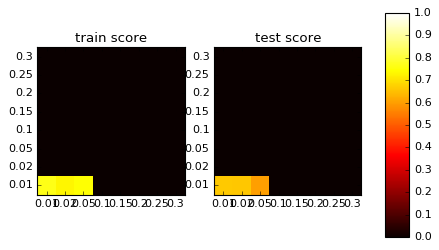

In [20]:
fig, ax = plt.subplots(ncols=2)
vmin = min(train_scores.min(), test_scores.min())
r = ax[0].imshow(train_scores.mean(axis=2), interpolation='nearest', cmap=plt.cm.hot, vmax=1,vmin=vmin, origin='lower')
ax[0].set_xticks(np.arange(len(percent_labels_range)))
ax[0].set_xticklabels(percent_labels_range)
ax[0].set_yticks(np.arange(len(percent_links_range)))
ax[0].set_yticklabels(percent_links_range)
ax[0].set_title('train score')

r = ax[1].imshow(test_scores.mean(axis=2), interpolation='nearest', cmap=plt.cm.hot, vmax=1,vmin=vmin, origin='lower')
ax[1].set_xticks(np.arange(len(percent_labels_range)))
ax[1].set_xticklabels(percent_labels_range)
ax[1].set_yticks(np.arange(len(percent_links_range)))
ax[1].set_yticklabels(percent_links_range)
ax[1].set_title('test score')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(r, cax=cbar_ax)

In [21]:
help(np.savetxt)

Help on function savetxt in module numpy.lib.npyio:

savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
    Save an array to a text file.
    
    Parameters
    ----------
    fname : filename or file handle
        If the filename ends in ``.gz``, the file is automatically saved in
        compressed gzip format.  `loadtxt` understands gzipped files
        transparently.
    X : array_like
        Data to be saved to a text file.
    fmt : str or sequence of strs, optional
        A single format (%10.5f), a sequence of formats, or a
        multi-format string, e.g. 'Iteration %d -- %10.5f', in which
        case `delimiter` is ignored. For complex `X`, the legal options
        for `fmt` are:
            a) a single specifier, `fmt='%.4e'`, resulting in numbers formatted
                like `' (%s+%sj)' % (fmt, fmt)`
            b) a full string specifying every real and imaginary part, e.g.
                `' %.4e %+.4ej %.4e %+.4ej 

In [22]:
r = np.random.normal(size=10)

In [23]:
r


array([-1.15849773, -0.32685769, -0.38385084,  0.4636787 ,  0.93525559,
       -2.52477021,  0.51987001,  2.2582448 ,  0.11831111, -0.67441909])

In [24]:
np.savetxt('test.out', r)
rl = np.loadtxt('test.out')
rl

array([-1.15849773, -0.32685769, -0.38385084,  0.4636787 ,  0.93525559,
       -2.52477021,  0.51987001,  2.2582448 ,  0.11831111, -0.67441909])

In [25]:
print('%1.8e' % 1.0)

1.00000000e+00
